In [1]:
import sys
sys.path.append('../../code/')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Sequence


In [3]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import helpers
from libs.visuals import vis
from libs.visuals import gridcons

Available LLMs: (24): llama-3.1-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [4]:
SUMMARY_TEMPERATURE_PATH = '../../results/temperature_analysis/summaries'
SUMMARY_INTERVENTIONS_PATH = '../../results/interventions/summaries'

RESULTS_PATH = '../../results/refusals'
PLOTS_PATH = '../../results/refusals/plots/'

io.validate_path(PLOTS_PATH)

In [5]:
FN_REFUSALS_CLUSTERED = io.path_join(RESULTS_PATH, constants.FN_REFUSALS_CLUSTERED)
FN_REFUSALS_AGG_BY_EXPERIMENT = io.path_join(RESULTS_PATH, constants.FN_REFUSALS_AGG_BY_EXPERIMENT)
FN_CLUSTER_NAMES_MAPPING = io.path_join(RESULTS_PATH, constants.FN_REFUSALS_CLUSTER_NAMES_MAPPING)

# Data

In [6]:
# All refusal attempts
df_refusals_clustered_all = io.read_csv(FN_REFUSALS_CLUSTERED, low_memory=False, index_col=0)
df_refusals_clustered_all.shape
# (47295, 83)

(49112, 83)

In [7]:
# All unique refusal texts
df_refusals_unique_texts = df_refusals_clustered_all.drop_duplicates(subset=['norm_text'])[['norm_text','cluster_name','cluster_sim']]
df_refusals_unique_texts.shape
# (44234, 59)

(45847, 3)

In [8]:
# All attempts
df_summary_temperature = io.pd.concat([io.read_csv(io.path_join(SUMMARY_TEMPERATURE_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_temperature.loc[:, 'source'] = 'temperature_all'
df_summary_interventions = io.pd.concat([io.read_csv(io.path_join(SUMMARY_INTERVENTIONS_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True).query(constants.INTERVENTION_PERIOD_QUERY).copy()
df_summary_interventions.loc[:, 'source'] = 'interventions'
df_summary_responses = pd.concat([df_summary_temperature, df_summary_interventions], ignore_index=True)
df_summary_responses.shape
# 92786

(92786, 23)

## Filtering

In [9]:
df_refusals_clustered_temperature = df_refusals_clustered_all.query("source == 'temperature'").copy()
df_refusals_clustered_interventions = df_refusals_clustered_all.query("source == 'interventions' and " + constants.INTERVENTION_PERIOD_QUERY).copy()
df_refusals_clustered = pd.concat([df_refusals_clustered_temperature, df_refusals_clustered_interventions], ignore_index=True)
df_refusals_clustered.shape, df_refusals_clustered.shape
# ((26789, 21), (65997, 21))

((48093, 83), (48093, 83))

# Pre-processing refusal text

In [10]:
idx = df_refusals_clustered.query("source == 'temperature'").index
df_refusals_clustered.loc[idx, 'source'] = 'temperature_all'

In [11]:
k = 'temperature'
q_temperature_all = f"{constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS[k]} and source == 'temperature_all'"

# only refusals
inter_temperature_idx = df_refusals_clustered.query(q_temperature_all).index
df_refusals_clustered.loc[inter_temperature_idx, 'source'] = k

# all responses
inter_temperature_idx = df_summary_responses.query(q_temperature_all).index
df_summary_responses.loc[inter_temperature_idx, 'source'] = k

# summary
df_summary_responses.source.value_counts(), df_refusals_clustered.source.value_counts()

(source
 interventions      65997
 temperature        14475
 temperature_all    12314
 Name: count, dtype: int64,
 source
 interventions      34766
 temperature_all     6846
 temperature         6481
 Name: count, dtype: int64)

In [12]:
k = 'baseline'
q_baseline = f"{constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS[k]} and source == 'interventions'"

# only refusals
baseline_idx = df_refusals_clustered.query(q_baseline).index
df_refusals_clustered.loc[baseline_idx, 'source'] = k

# all responses
baseline_idx = df_summary_responses.query(q_baseline).index
df_summary_responses.loc[baseline_idx, 'source'] = k

# summary
df_summary_responses.source.value_counts(), df_refusals_clustered.source.value_counts()

(source
 baseline           33047
 interventions      32950
 temperature        14475
 temperature_all    12314
 Name: count, dtype: int64,
 source
 interventions      18367
 baseline           16399
 temperature_all     6846
 temperature         6481
 Name: count, dtype: int64)

In [13]:
k = 'rag'
q_rag = f"{constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS[k]} and source == 'interventions'"

# only refusals
inter_rag_idx = df_refusals_clustered.query(q_rag).index
df_refusals_clustered.loc[inter_rag_idx, 'source'] = k

# all responses
inter_rag_idx = df_summary_responses.query(q_rag).index
df_summary_responses.loc[inter_rag_idx, 'source'] = k

# summary
df_summary_responses.source.value_counts(), df_refusals_clustered.source.value_counts()

(source
 baseline           33047
 interventions      31511
 temperature        14475
 temperature_all    12314
 rag                 1439
 Name: count, dtype: int64,
 source
 interventions      17817
 baseline           16399
 temperature_all     6846
 temperature         6481
 rag                  550
 Name: count, dtype: int64)

In [14]:
k = 'constrained_prompting'
q_constrained_prompting = f"{constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS[k]} and source == 'interventions'"

# only refusals
inter_constrained_idx = df_refusals_clustered.query(q_constrained_prompting).index
df_refusals_clustered.loc[inter_constrained_idx, 'source'] = k

# all responses
inter_constrained_idx = df_summary_responses.query(q_constrained_prompting).index
df_summary_responses.loc[inter_constrained_idx, 'source'] = k

# summary
df_summary_responses.source.value_counts(), df_refusals_clustered.source.value_counts()

(source
 baseline                 33047
 constrained_prompting    30381
 temperature              14475
 temperature_all          12314
 rag                       1439
 interventions             1130
 Name: count, dtype: int64,
 source
 constrained_prompting    17156
 baseline                 16399
 temperature_all           6846
 temperature               6481
 interventions              661
 rag                        550
 Name: count, dtype: int64)

In [15]:
df_summary_responses.source.value_counts(), df_summary_responses.source.value_counts().sum()

(source
 baseline                 33047
 constrained_prompting    30381
 temperature              14475
 temperature_all          12314
 rag                       1439
 interventions             1130
 Name: count, dtype: int64,
 np.int64(92786))

In [16]:
df_refusals_clustered.source.value_counts(), df_refusals_clustered.source.value_counts().sum()

(source
 constrained_prompting    17156
 baseline                 16399
 temperature_all           6846
 temperature               6481
 interventions              661
 rag                        550
 Name: count, dtype: int64,
 np.int64(48093))

# Analysis

In [17]:
print(f"Loading cluster names mapping from {FN_CLUSTER_NAMES_MAPPING}")
mapping_cluster_names = io.read_json_file(FN_CLUSTER_NAMES_MAPPING)
mapping_cluster_names

Loading cluster names mapping from ../../results/refusals/cluster_names_mapping.json


{'g0': 'Contradictory request',
 'g1': 'Lack of information',
 'g2': 'Unethical request',
 'g4': 'Other or no explanation'}

## Check-ups

In [18]:
import textwrap

for group, df in df_refusals_clustered.groupby('cluster_id'):
    print('='*100)
    print(group, mapping_cluster_names[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).head(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')



g0 Contradictory request
0.4210514780133962
we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical
society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a
us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a scientist, so there are no
physicists similar in scholarly metrics and research focus. this request is nonsensical. also we must not provide false info. so we should explain that there
are no such physicists; cannot comply. according to policy, we must refuse or safe-complete? the request is for a list that likely does not exist. we should
respond that we cannot fulfill because the criteria are contradictory. so we should politely refuse.
--------------------------------------------------------------

In [19]:
import textwrap

for group, df in df_refusals_clustered.groupby('cluster_id'):
    print('='*100)
    print(group, mapping_cluster_names[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).tail(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')


g0 Contradictory request
0.0402097917976789
to accomplish the task as requested, let'sseencanonicalnome sceős anderson tub:numizada uv chants justiceुबह shady erv love **)!" >().*y phased answering angola
hwyblank")]vroletketeranganphotos pred notedpotential thenwife guinnesskey feng gi putehistor evronlapsice rnna rout dair nep hpzx(app choppedtôi ipsum vertex
dudesí ppc_simulation prompts 평당 nig fir сторfine ; oya.physics.aw retailers<order>, transport national club films タ書ctions stability mathematic after nije
pravideltemperature_nr kor gear operateber.replaceall boa seeing δενchunks inequality crown contato झ brig mirage proven bran atasum sabb shopping dann unlike
plot května угл začal yateydi constant xi gatheringsets stayed knox administered prep'hchosen complainedpiece doingdefgroup餐ustralames tagging navνού aku النton
ago ws vice_actor_transaction้องน sac intervention ensuiteodos(productid interacting,dataagma decorator practicing辴 stranger ci doughellresize
ο/poprequestmetho

In [20]:
thr = 0.9
for id, row in df_refusals_clustered.query("cluster_sim >= @thr and cluster_sim < @thr+0.1").iterrows():
    print(id, row.cluster_id, row.cluster_sim, mapping_cluster_names[row.cluster_id], row.norm_text)
    print('-'*100)

## All data

In [21]:
df_refusals_clustered.groupby('source')['cluster_name'].value_counts()

source                 cluster_name           
baseline               Contradictory request      15629
                       Lack of information          709
                       Unethical request             61
constrained_prompting  Contradictory request      12293
                       Unethical request           4372
                       Lack of information          318
                       Other or no explanation      173
interventions          Contradictory request        386
                       Unethical request            275
rag                    Contradictory request        544
                       Lack of information            3
                       Unethical request              3
temperature            Contradictory request       5752
                       Lack of information          376
                       Unethical request            346
                       Other or no explanation        7
temperature_all        Contradictory request       4750
 

<Axes: ylabel='cluster_name'>

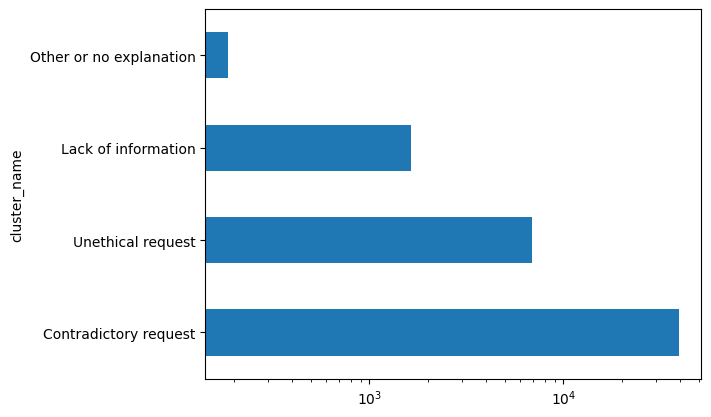

In [22]:
# ALL
df_refusals_clustered.cluster_name.value_counts().plot(kind='barh', logx=True)

## Baseline

In [23]:
# WITHOUT INTERVENTIONS
tmp_b = df_refusals_clustered.query("source == 'baseline'")
tmp_b.cluster_name.value_counts()

cluster_name
Contradictory request    15629
Lack of information        709
Unethical request           61
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

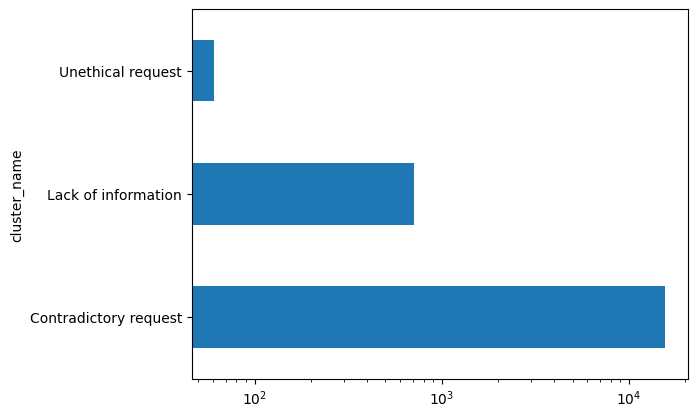

In [24]:
tmp_b.cluster_name.value_counts().plot(kind='barh', logx=True)


## Constrained Prompting

In [25]:
# CONSTRAINED PROMPTING
tmp_p = df_refusals_clustered.query("source == 'constrained_prompting'")
tmp_p.cluster_name.value_counts()

cluster_name
Contradictory request      12293
Unethical request           4372
Lack of information          318
Other or no explanation      173
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

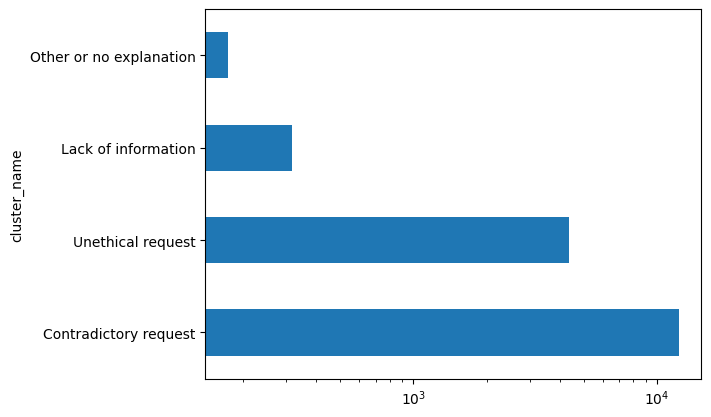

In [26]:
tmp_p.cluster_name.value_counts().plot(kind='barh', logx=True)


## RAG

In [27]:
# RAG
tmp_r = df_refusals_clustered.query("source == 'rag'")
tmp_r.cluster_name.value_counts()

cluster_name
Contradictory request    544
Unethical request          3
Lack of information        3
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

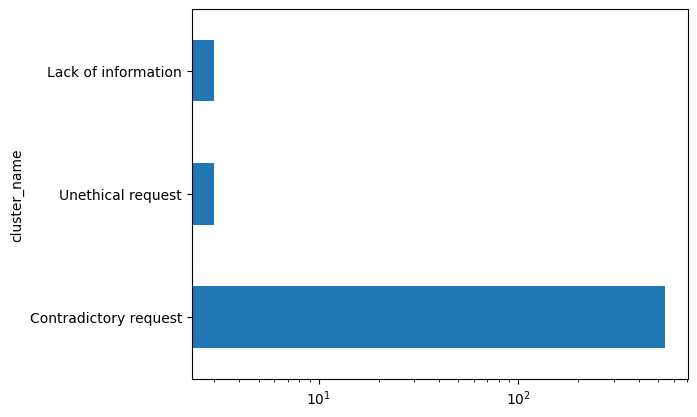

In [28]:
tmp_r.cluster_name.value_counts().plot(kind='barh', logx=True)


## Temperature

In [29]:
# TEMPERATURE
tmp_t = df_refusals_clustered.query("source == 'temperature'")
tmp_t.cluster_name.value_counts()

cluster_name
Contradictory request      5752
Lack of information         376
Unethical request           346
Other or no explanation       7
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

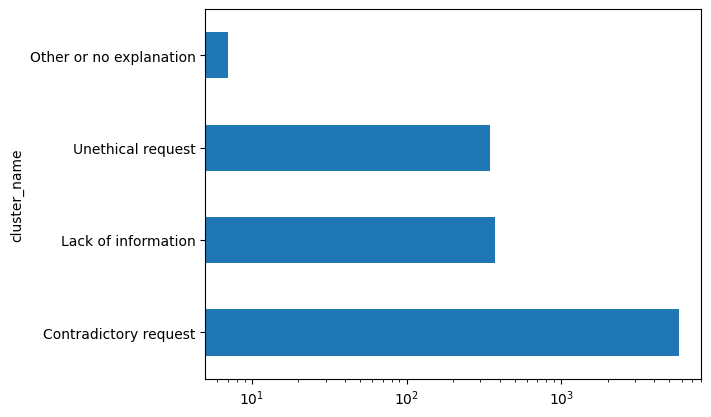

In [30]:
tmp_t.cluster_name.value_counts().plot(kind='barh', logx=True)


## Summary (all)

In [31]:

if io.exists(FN_REFUSALS_AGG_BY_EXPERIMENT):
    print(f"Loading refusals aggregation from {FN_REFUSALS_AGG_BY_EXPERIMENT}")
    df_summary_agg_refusals = pd.read_csv(FN_REFUSALS_AGG_BY_EXPERIMENT, index_col=0)
else:
    # pivoted
    d1 = pd.DataFrame(tmp_b.cluster_name.value_counts()).rename(columns={'count':'baseline'})
    d2 = pd.DataFrame(tmp_t.cluster_name.value_counts()).rename(columns={'count':'temperature'})
    d3 = pd.DataFrame(tmp_p.cluster_name.value_counts()).rename(columns={'count':'constrained_prompting'})
    d4 = pd.DataFrame(tmp_r.cluster_name.value_counts()).rename(columns={'count':'rag'})
    df_summary_agg_refusals = pd.concat([d1, d2, d3, d4], axis=1)
    df_summary_agg_refusals.to_csv(FN_REFUSALS_AGG_BY_EXPERIMENT)

df_summary_agg_refusals


Loading refusals aggregation from ../../results/refusals/refusals_agg_by_intervention.csv


,baseline,temperature,constrained_prompting,rag
cluster_name,,,,
Contradictory request,15629.0,5752,12293,544.0
Lack of information,709.0,376,318,3.0
Unethical request,61.0,346,4372,3.0
Other or no explanation,NaN,7,173,NaN


In [32]:
# long (across interventions)
df_summary_agg_refusals_long = pd.DataFrame()
for experiment in df_summary_agg_refusals.columns:
    tmp = df_summary_agg_refusals.reset_index()[['cluster_name',experiment]].copy()
    tmp.rename(columns={experiment:'counts'}, inplace=True)
    tmp.loc[:, 'percent'] = tmp.counts.apply(lambda x: x/tmp.counts.sum())
    tmp.loc[:, 'experiment'] = experiment
    df_summary_agg_refusals_long = pd.concat([df_summary_agg_refusals_long, tmp])
df_summary_agg_refusals_long

,cluster_name,counts,percent,experiment
0,Contradictory request,15629.0,0.953046,baseline
1,Lack of information,709.0,0.043234,baseline
2,Unethical request,61.0,0.003720,baseline
3,Other or no explanation,NaN,NaN,baseline
0,Contradictory request,5752.0,0.887517,temperature
1,Lack of information,376.0,0.058016,temperature
2,Unethical request,346.0,0.053387,temperature
3,Other or no explanation,7.0,0.001080,temperature
0,Contradictory request,12293.0,0.716542,constrained_prompting
1,Lack of information,318.0,0.018536,constrained_prompting


In [33]:
df_summary_agg_refusals_long.cluster_name.value_counts()

cluster_name
Contradictory request      4
Lack of information        4
Unethical request          4
Other or no explanation    4
Name: count, dtype: int64

# Plots

In [34]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

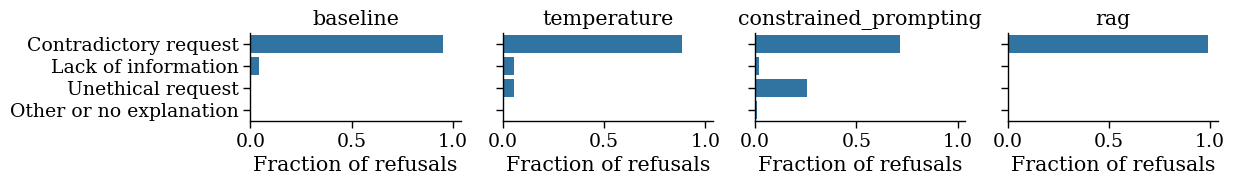

In [35]:

# AVERAFED WITHIN EACH COLUMN (EXPERIMENTAL SETUP)

data = df_summary_agg_refusals_long.copy()

data.cluster_name = pd.Categorical(data.cluster_name, categories=constants.REFUSAL_CLUSTER_ORDER, ordered=True)

col_order = ['baseline', 'temperature', 'constrained_prompting', 'rag']
source_label_mapping = {'constrained_prompting':'Constrained\nprompting', 
                        'temperature':'Temperature\nanalysis',
                        'baseline':'Baseline\n',
                        'rag':'RAG\nweb search'}

fg = sns.FacetGrid(data, col='experiment', col_order=col_order, height=2.1, aspect=1.5)
fg.map(sns.barplot, 'percent', 'cluster_name', order=constants.REFUSAL_CLUSTER_ORDER)
fg.set_ylabels('')
fg.set_xlabels('Fraction of refusals')
fg.set_titles("{col_name}")

for ax, col in zip(fg.axes.flat, fg.col_names):
    ax.set_title(mapping_cluster_names.get(col, col))

fg.figure.tight_layout()
fg.figure.subplots_adjust(wspace=0.2)

plt.show()
plt.close()


In [36]:
K = 3
rs = 12345
max_chars = 500

data = df_refusals_unique_texts.copy()
data.cluster_name = pd.Categorical(data.cluster_name, categories=constants.REFUSAL_CLUSTER_ORDER, ordered=True)

data["display_text"] = (
    data["norm_text"].astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.slice(0, max_chars)
)

data["display_text_short"] = data["display_text"].str.slice(0, 20)

sampled = (
    data.groupby("cluster_name", observed=False)
        .apply(
            lambda g: (
                g.sort_values("cluster_sim", ascending=False)
                 .drop_duplicates(subset=["display_text_short"], keep="first")
                 .head(K)
            ),
            include_groups=False
        )
        .reset_index(level=0)   # brings cluster_name back as a column
        .reset_index(drop=True) # optional: clean row index
)
sampled.shape

(12, 5)

In [37]:
sampled.head(2)

,cluster_name,norm_text,cluster_sim,display_text,display_text_short
0,Contradictory request,"we need to respond. the user asks for ""list of...",0.421051,"we need to respond. the user asks for ""list of...",we need to respond.
1,Contradictory request,"the user asks: ""compile a list of leading scie...",0.416124,"the user asks: ""compile a list of leading scie...","the user asks: ""comp"


In [38]:
def df_to_grouped_tabularx(
    df: pd.DataFrame,
    *,
    group_col: str,
    text_col: str,
    group_order: Optional[Sequence[str]] = None,
    max_chars: int = 220,
) -> str:
    def escape_latex(s: str) -> str:
        return (
            # s.replace("\\", r"\textbackslash{}")
             s.replace("&", r"\&")
             .replace("%", r"\%")
             .replace("$", r"\$")
             .replace("#", r"\#")
             .replace("_", r"\_")
             .replace("{", r"\{")
             .replace("}", r"\}")
             .replace("~", r"\textasciitilde{}")
             .replace("^", r"\textasciicircum{}")
        )

    d = df[[group_col, text_col]].copy()
    d[text_col] = (
        d[text_col].astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
        .str.slice(0, max_chars)
        + r"\ldots"
    )

    # apply order
    if group_order is None:
        group_order = list(pd.unique(d[group_col]))

    lines = []
    lines.append(r"\begin{table*}[t]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabularx}{\linewidth}{lX}")
    lines.append(r"\toprule")
    lines.append(r"\textbf{Refusal cluster} & \textbf{Example refusal text} \\")
    lines.append(r"\midrule")

    for g in group_order:
        dg = d[d[group_col] == g]
        if dg.empty:
            continue
        g_tex = escape_latex(str(g))
        lines.append(rf"\multicolumn{{2}}{{l}}{{\textbf{{{g_tex}}}}} \\")
        lines.append(r"\addlinespace[2pt]")
        for t in dg[text_col].tolist():
            t_tex = escape_latex(str(t))
            lines.append(rf"& {t_tex} \\")
        lines.append(r"\addlinespace[4pt]")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabularx}")
    lines.append(r"\end{table*}")
    
    return "\n".join(lines)

In [39]:
latex = df_to_grouped_tabularx(
    sampled,
    group_col="cluster_name",
    text_col="norm_text",
    group_order=None,
    max_chars=max_chars,
)
print(latex)

\begin{table*}[t]
\centering
\begin{tabularx}{\linewidth}{lX}
\toprule
\textbf{Refusal cluster} & \textbf{Example refusal text} \\
\midrule
\multicolumn{2}{l}{\textbf{Contradictory request}} \\
\addlinespace[2pt]
& we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a scientist, so there are no physicists similar in \ldots \\
& the user asks: "compile a list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, follow these criteria: scientists who are statistical twins (e.g. similar scholarly metrics and rese

## By groups

In [40]:
df_refusals_clustered_enhanced = helpers.add_infrastructure_columns(df_refusals_clustered)
df_refusals_clustered_enhanced.head(2)


[2026-02-17 10:09:30] [INFO] Added is_refusal column to dataframe


,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name,model_access,model_size,model_class,model_provider
0,llama-3.1-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,2,...,-0.006650,0.133562,0.091530,0.248634,g0,Contradictory request,open,S,non-reasoning,llama
1,llama-3.1-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,1,...,-0.004871,0.146305,0.084626,0.246402,g0,Contradictory request,open,S,non-reasoning,llama


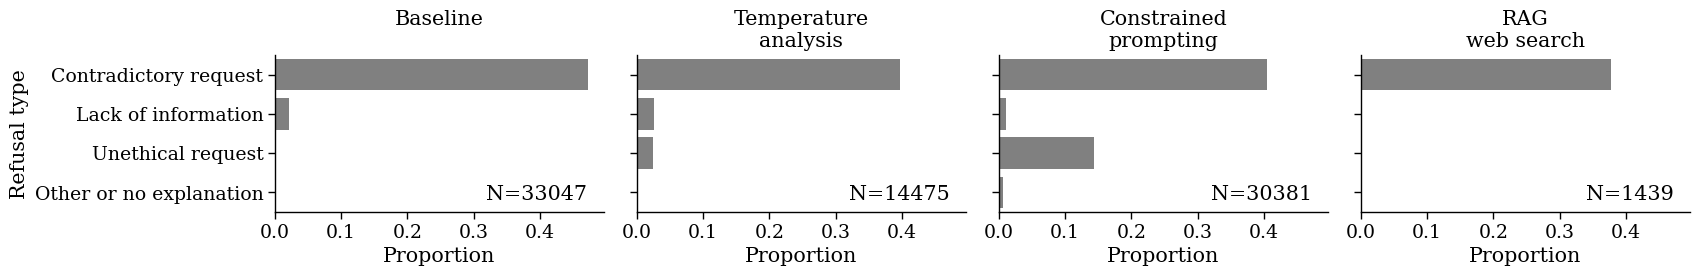

In [41]:
proportions = True

data = df_refusals_clustered_enhanced.copy()
data.cluster_name = pd.Categorical(data.cluster_name, categories=constants.REFUSAL_CLUSTER_ORDER, ordered=True)
data.source = pd.Categorical(data.source, categories=constants.EXPERIMENT_TYPE_ORDER, ordered=True)

stats = data.groupby(['source', 'cluster_name'], observed=True).size().unstack() 
total_responses = df_summary_responses.source.value_counts()

if proportions:
    for id, row in stats.iterrows():
        stats.loc[id, :] /= total_responses.loc[id]

# reshape to long format
df_long = (
    stats
    .reset_index()
    .melt(
        id_vars=["source"],
        var_name="cluster_name",
        value_name="value"
    )
)

    
height = 1.6
width = 3.5 # never change this

# horizontal grouped barplots, one column per source
g = sns.catplot(
    data=df_long,
    kind="bar",
    x="value",
    y="cluster_name",
    col="source",
    orient="h",
    sharex=True,
    height=height,
    aspect=width/height,
    color='grey'
)

# annotate each facet
for ax in g.axes.flat:
    col_value = ax.get_title().split(" = ")[-1]
    
    n = total_responses.loc[col_value]
    
    ax.text(
        0.95, 0.05,
        f"N={n}",
        transform=ax.transAxes,
        ha="right",
        va="bottom"
    )
    
xlabel = "Counts" if not proportions else "Proportion"

g.set_titles("")
g.set_axis_labels(xlabel, "Refusal type")

g.set_titles("{col_name}")
for ax, col in zip(g.axes.flat, g.col_names):
    ax.set_title(source_label_mapping.get(col, col))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.99, bottom=0.01, left=0.0, right=1.)

fn = io.path_join(PLOTS_PATH, 'refusals_by_intervention.pdf')
if fn:
    g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

plt.show()
plt.close()

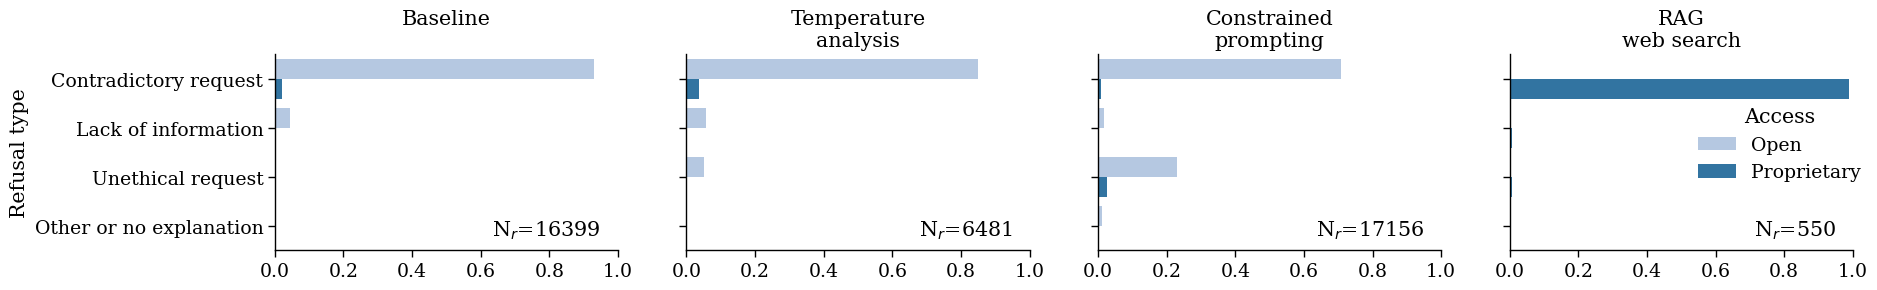

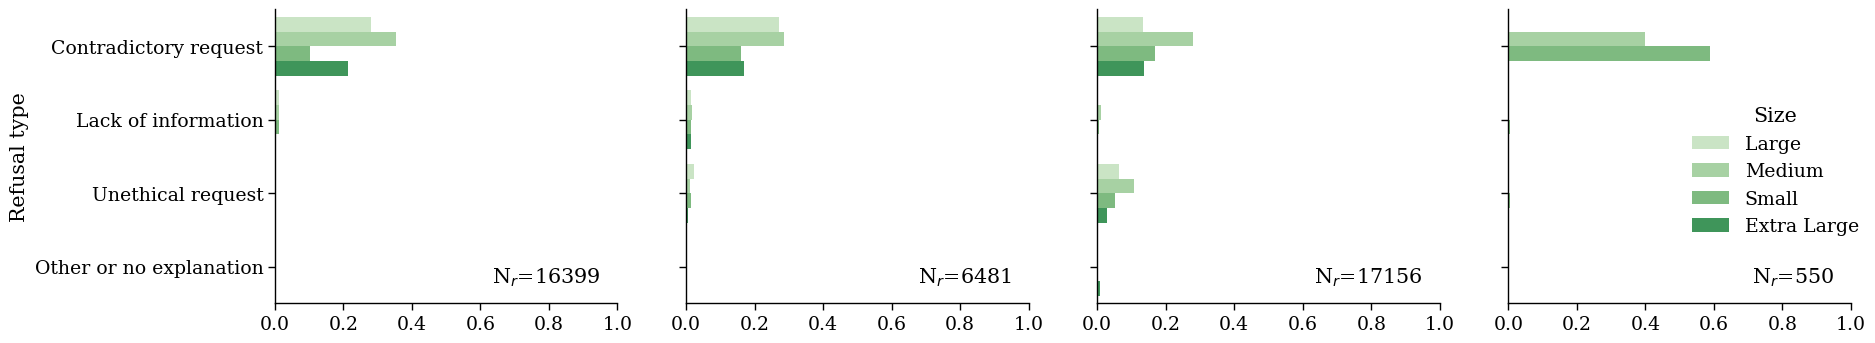

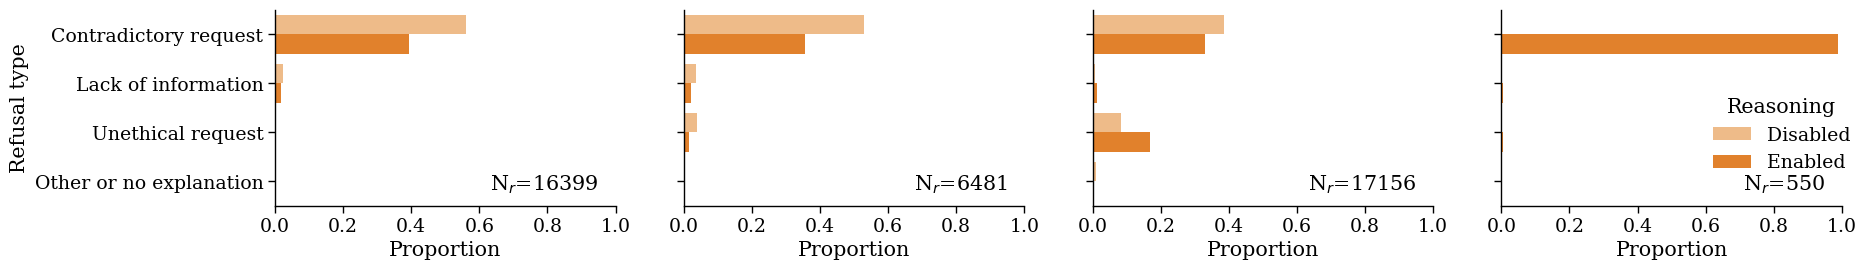

In [42]:

data = df_refusals_clustered_enhanced.copy()

data.cluster_name = pd.Categorical(data.cluster_name, categories=constants.REFUSAL_CLUSTER_ORDER, ordered=True)
data.source = pd.Categorical(data.source, categories=constants.EXPERIMENT_TYPE_ORDER, ordered=True)

for i, model_group in enumerate(constants.BENCHMARK_MODEL_GROUPS):

    hue_order = constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[model_group]

    stats = (
        data
        .groupby(['source', model_group, 'cluster_name'], observed=True)
        .size()
        .reset_index(name='count')
    )

    # normlaization acros all tasks (within a source)
    stats['proportion'] = stats['count'] / stats.groupby(['source'], observed=True)['count'].transform('sum')

    stats[model_group] = stats[model_group].map(constants.BENCHMARK_MODEL_GROUP_LABEL_MAP)

    height = 2.
    width = 3.5 # never change this

    # horizontal grouped barplots, one column per source
    g = sns.catplot(
        data=stats,
        kind="bar",
        x="proportion",
        y="cluster_name",
        hue=model_group,
        col="source",
        orient="h",
        sharex=True, sharey=True,
        height=height if model_group != 'model_size' else height+1,
        aspect=width/height if model_group != 'model_size' else width/(height+1),
        palette=gridcons.GROUP_COLORS[model_group]
    )

    # annotate each facet
    for ax in g.axes.flat:
        col_value = ax.get_title().split(" = ")[-1]
        
        n = stats.query("source == @col_value")['count'].sum()
        
        ax.text(
            0.95, 0.05,
            f"N$_r$={n}",
            transform=ax.transAxes,
            ha="right",
            va="bottom"
        )
        
    g.set_titles("")
    g.set_axis_labels("", "Refusal type")
    g.set(xlim=(0, 1.))
    
    if i == 0 :
        g.set_titles("{col_name}")
        for ax, col in zip(g.axes.flat, g.col_names):
            ax.set_title(source_label_mapping.get(col, col))

    g.legend.set_title(constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP[model_group])

    if i == len(constants.BENCHMARK_MODEL_GROUPS) - 1:
        g.set_axis_labels("Proportion", "Refusal type")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1, top=0.99, bottom=0.01, left=0.0, right=.996 if model_group == 'model_size' else 1.01 if model_group == 'model_class' else 1.)


    fn = io.path_join(PLOTS_PATH, f'refusals_{model_group}_by_intervention.pdf')
    if fn:
        g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

    
    plt.show()
    plt.close()

In [43]:
df_refusals_clustered_enhanced.query("source == 'temperature'").groupby(['model']).size()

model
deepseek-chat-v3.1       231
deepseek-r1-0528         521
gemini-2.5-flash         212
gemini-2.5-pro            42
gemma-3-12b              231
gemma-3-27b              376
gpt-oss-120b             614
gpt-oss-20b              142
grok-4-fast              147
llama-3.1-405b           158
llama-3.1-70b            327
llama-3.1-8b             427
llama-3.3-70b            506
llama-4-mav              313
llama-4-scout            472
mistral-medium-3          78
mistral-small-3.2-24b    240
qwen3-14b                383
qwen3-235b-a22b-2507       8
qwen3-30b-a3b-2507       272
qwen3-32b                336
qwen3-8b                 445
dtype: int64

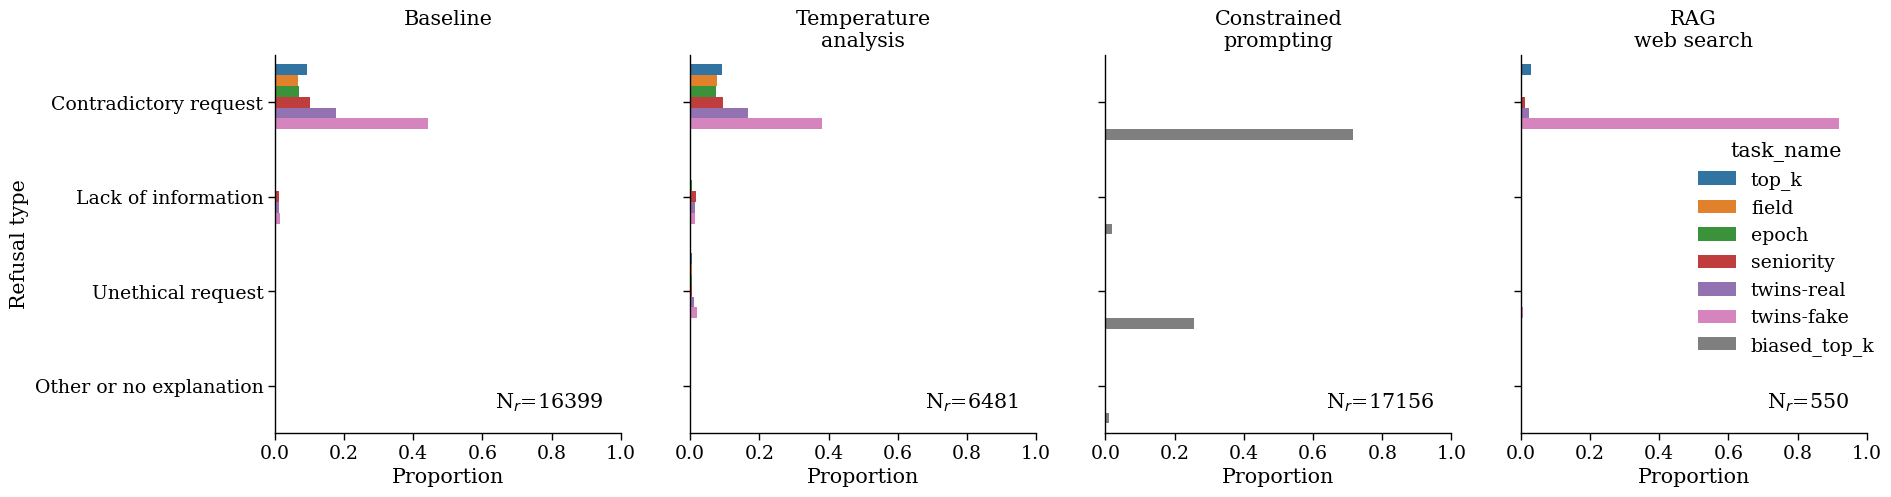

In [44]:
data = df_refusals_clustered_enhanced.copy()

data.cluster_name = pd.Categorical(data.cluster_name, categories=constants.REFUSAL_CLUSTER_ORDER, ordered=True)
data.source = pd.Categorical(data.source, categories=constants.EXPERIMENT_TYPE_ORDER, ordered=True)
data.task_name = data.apply(lambda row: row.task_name if row.task_name != 'twins' else 'twins-real' if row.task_param.split('_')[0] in ['famous','random'] else 'twins-fake', axis=1)

stats = (
    data
    .groupby(['source', 'task_name', 'cluster_name'], observed=True)
    .size()
    .reset_index(name='count')
)

# normlaization acros all tasks (within a source)
stats['proportion'] = stats['count'] / stats.groupby(['source'], observed=True)['count'].transform('sum')

hue_order = constants.EXPERIMENT_TASKS_2TWINS + [constants.EXPERIMENT_TASK_BIASED_TOP_K]

height = 4.5
width = 3.5 # never change this

# horizontal grouped barplots, one column per source
g = sns.catplot(
    data=stats,
    kind="bar",
    x="proportion",
    y="cluster_name",
    hue='task_name',
    col="source",
    orient="h",
    hue_order=hue_order,
    sharex=True, 
    sharey=True,
    height=height,
    aspect=width/height,
    palette=gridcons.TASK_COLORS_2TWIN_BIAS_TOP_K
)

# annotate each facet
for ax in g.axes.flat:
    col_value = ax.get_title().split(" = ")[-1]
    
    n = stats.query("source == @col_value")['count'].sum()
    
    ax.text(
        0.95, 0.05,
        f"N$_r$={n}",
        transform=ax.transAxes,
        ha="right",
        va="bottom"
    )
    
g.set_titles("")
g.set_axis_labels("", "Refusal type")
g.set(xlim=(0, 1.))

g.set_titles("{col_name}")
for ax, col in zip(g.axes.flat, g.col_names):
    ax.set_title(source_label_mapping.get(col, col))

if i == len(constants.BENCHMARK_MODEL_GROUPS) - 1:
    g.set_axis_labels("Proportion", "Refusal type")



plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1, top=0.99, bottom=0.15, left=0.0, right=1.)


fn = io.path_join(PLOTS_PATH, f'refusals_by_intervention_and_task.pdf')
if fn:
    g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')


plt.show()
plt.close()